## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

# Não foi possível obter um ajuste aceitável para este conjunto de dados!!!

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'MA'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-44.32780,-4.729400,111.800,977998.10,977998.166766,-0.066766
1,-44.33030,-4.750300,98.310,978002.15,978002.266939,-0.116939
2,-44.35640,-4.898100,94.610,978005.51,978003.978873,1.531127
3,-44.37310,-4.913600,96.440,978004.99,978003.795916,1.194084
4,-44.44280,-5.041400,118.140,978004.48,978002.814639,1.665361
...,...,...,...,...,...,...
602,-43.38973,-3.204091,48.447,978035.54,978031.803141,3.736859
603,-44.48577,-5.302927,86.751,978016.51,978013.277394,3.232606
604,-46.15702,-5.816454,206.514,977968.56,977965.468859,3.091141
605,-45.23392,-5.508131,129.386,977999.85,977997.976587,1.873413


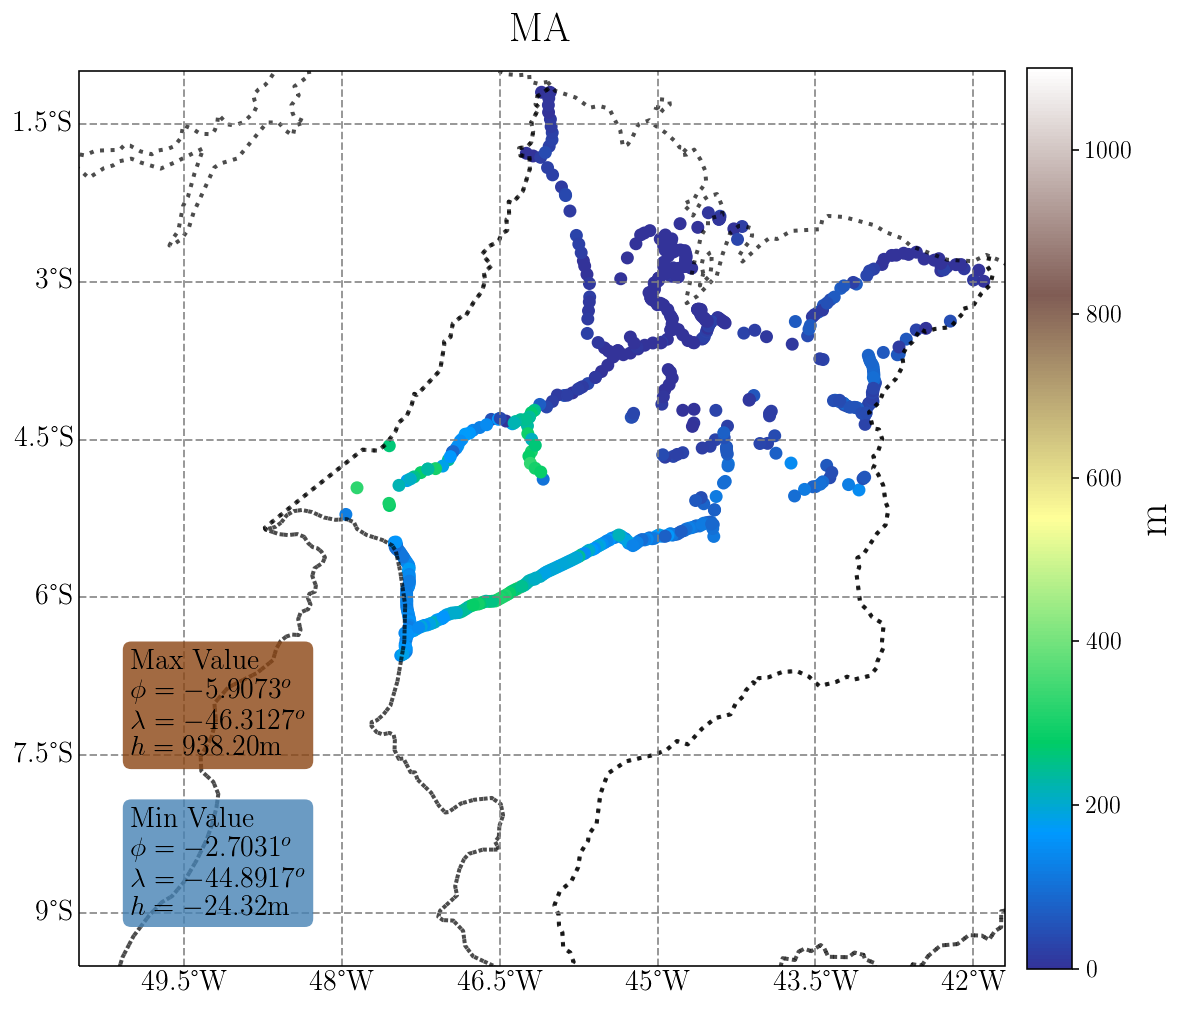

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(10.,12.), region=[-50.5,-41.7,-9.5,-1.], \
          sign=(-50,-50,-7.5,-9), cmap='terrain', lim_val=(True,True,0.,1100.), shrink=0.69)

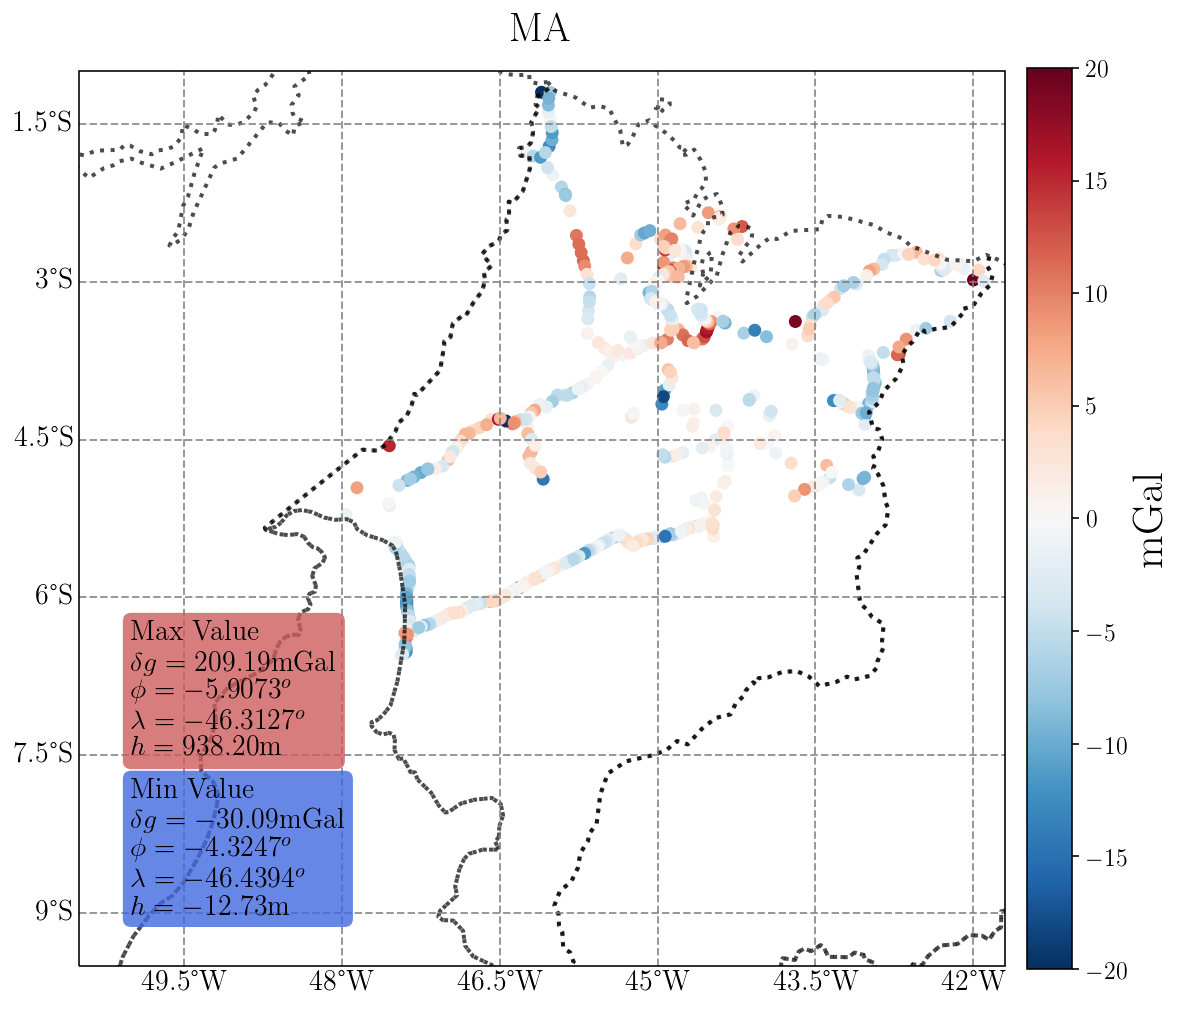

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(10.,12.), region=[-50.5,-41.7,-9.5,-1.], \
          sign=(-50,-50,-7.5,-9), lim_val=(True, 20.), shrink=0.69)

In [8]:
# index = np.argmax(df.ALT.values)
# print('MAX', index, df.ALT[index], df.DIST[index])

# index = np.argmin(df.ALT.values)
# print('MIN', index, df.ALT[index], df.DIST[index])

In [9]:
index_max = np.argmax(df.DIST.values)
print('MAX', index_max, df.ALT[index_max], df.DIST[index_max])

index_min = np.argmin(df.DIST.values)
print('MIN', index_min, df.ALT[index_min], df.DIST[index_min])
print(disturb.size)

MAX 477 938.2 209.18993549991865
MIN 324 -12.73 -30.090492600109428
607


In [10]:
disturb = np.delete(df.DIST.values, np.array(index_max))
longitude = np.delete(df.LONG.values, np.array(index_max))
latitude = np.delete(df.LAT.values, np.array(index_max))
altitude = np.delete(df.ALT.values, np.array(index_max))
print(disturb.size, longitude.size, latitude.size, altitude.size)

606 606 606 606


In [11]:
index_max = np.argmax(disturb)
print('MAX', index_max, altitude[index_max], disturb[index_max])

MAX 438 8.65 25.406903499970213


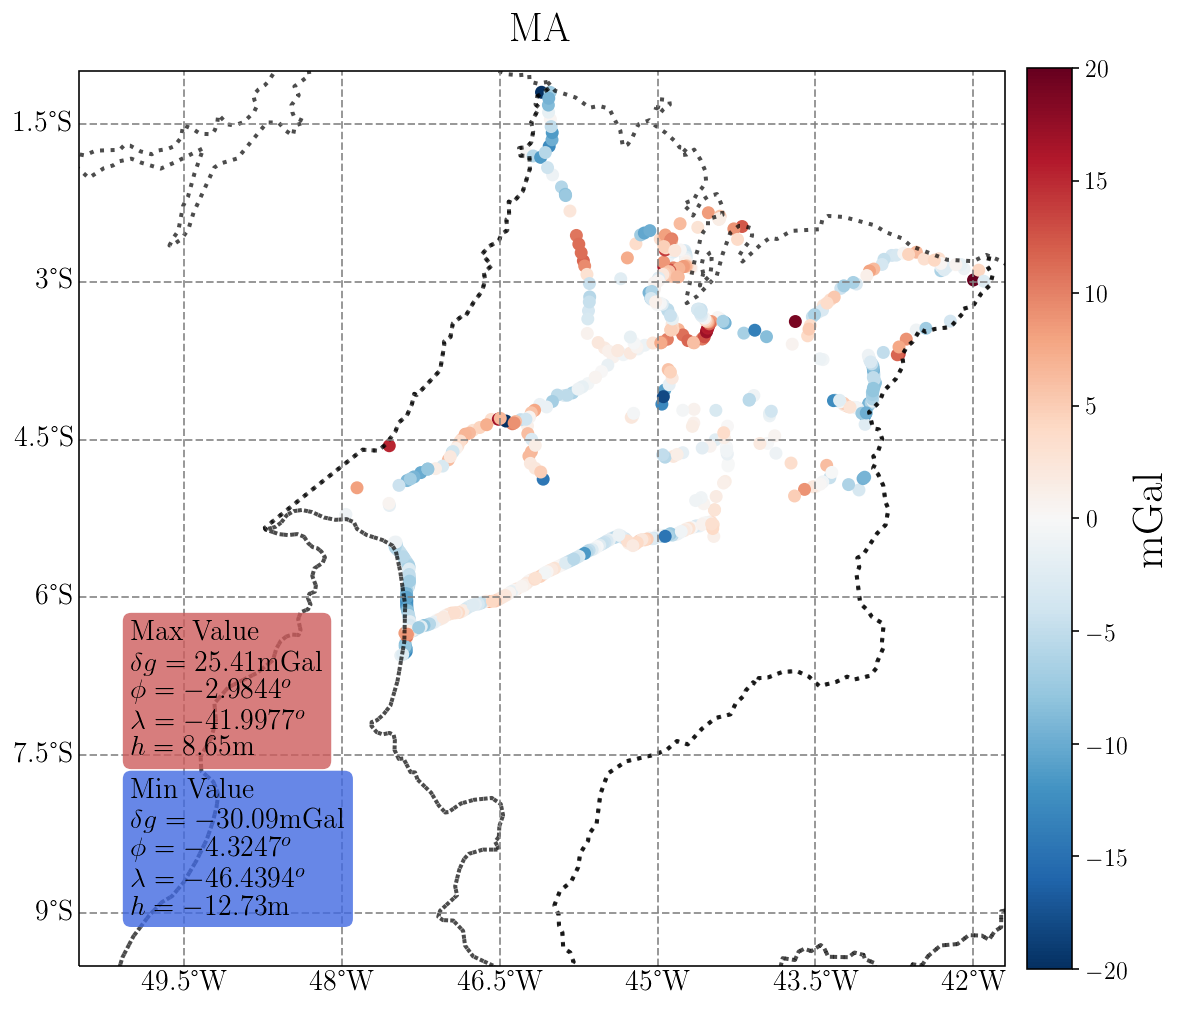

In [12]:
point_map(longitude, latitude, altitude, disturb, uf, fig_size=(10.,12.), region=[-50.5,-41.7,-9.5,-1.], \
          sign=(-50,-50,-7.5,-9), lim_val=(True, 20.), shrink=0.69)

### Calculating rotation matrices and Cartesian coordinates

In [13]:
# Calculating Cartesian coordinates
# x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
# R = np.array(rotation_matrix(df.LONG, df.LAT))
x, y, z = geodetic2cartesian(longitude, latitude, altitude)
R = np.array(rotation_matrix(longitude, latitude))

## Estimating the first set of point-mass parameters

In [14]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [15]:
indl = np.arange(disturb.size)
mi_c = 1e-30
hcl = 4000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

4000.0 <class 'numpy.ndarray'>


In [16]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]
# latcl = latitude[indl]
# loncl = longitude[indl]

In [17]:
Rcl = R[:, indl]

In [18]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
# Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
Lay = EqLayer(longitude, latitude, np.zeros_like(longitude)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(606, 606)


In [19]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [20]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

606


In [21]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [22]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

1.4710934902241415

In [23]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [24]:
rabs_max.append(rabs_max_l)

In [25]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

1.4710934902241415


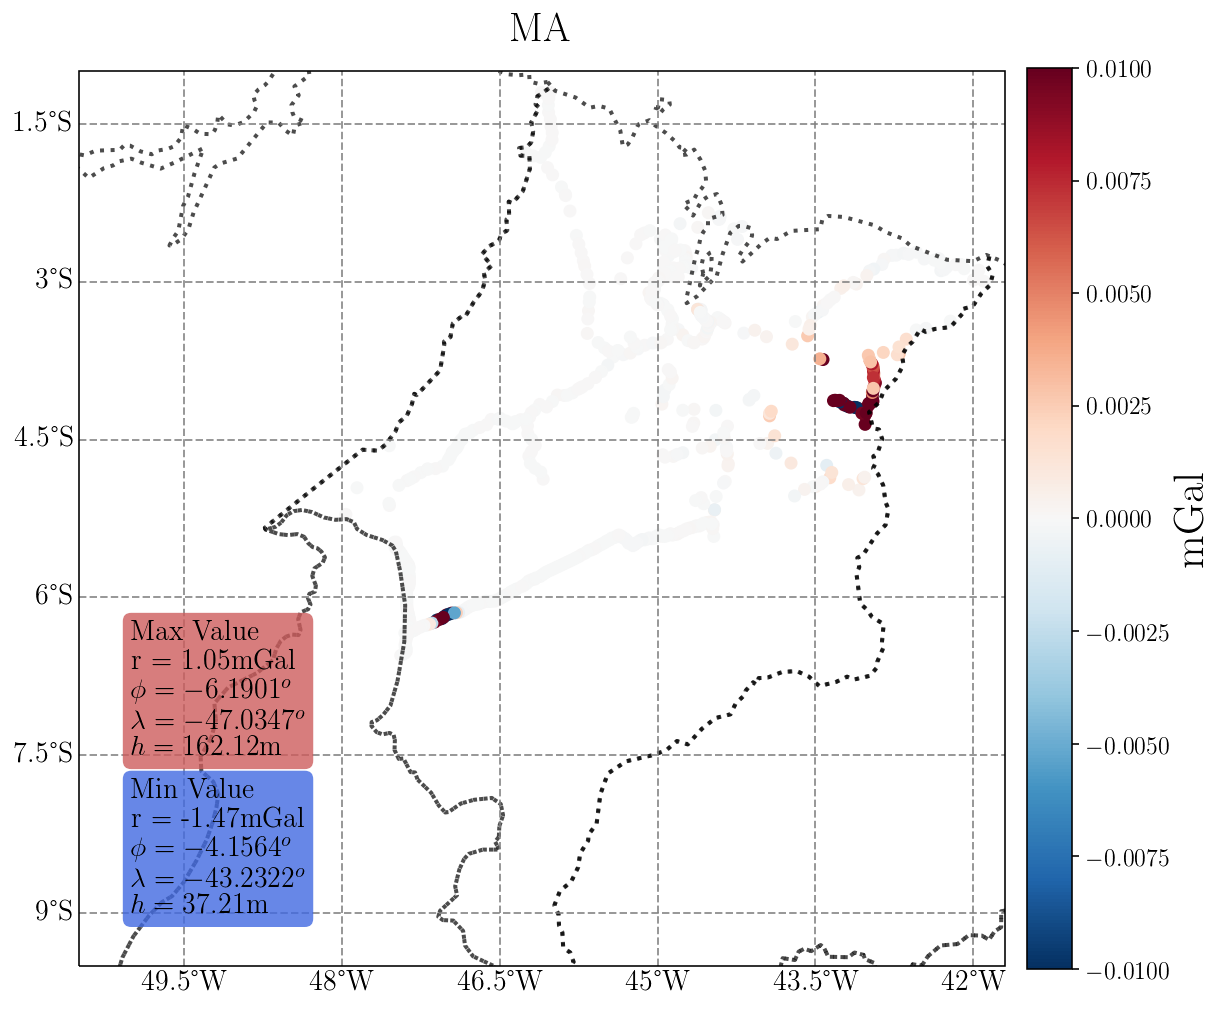

In [26]:
point_map(longitude, latitude, altitude, rc, uf, fig_size=(10.,12.), region=[-50.5,-41.7,-9.5,-1.], \
          sign=(-50,-50,-7.5,-9), shrink=0.69, residual=True, lim_val=(True, 1e-2))

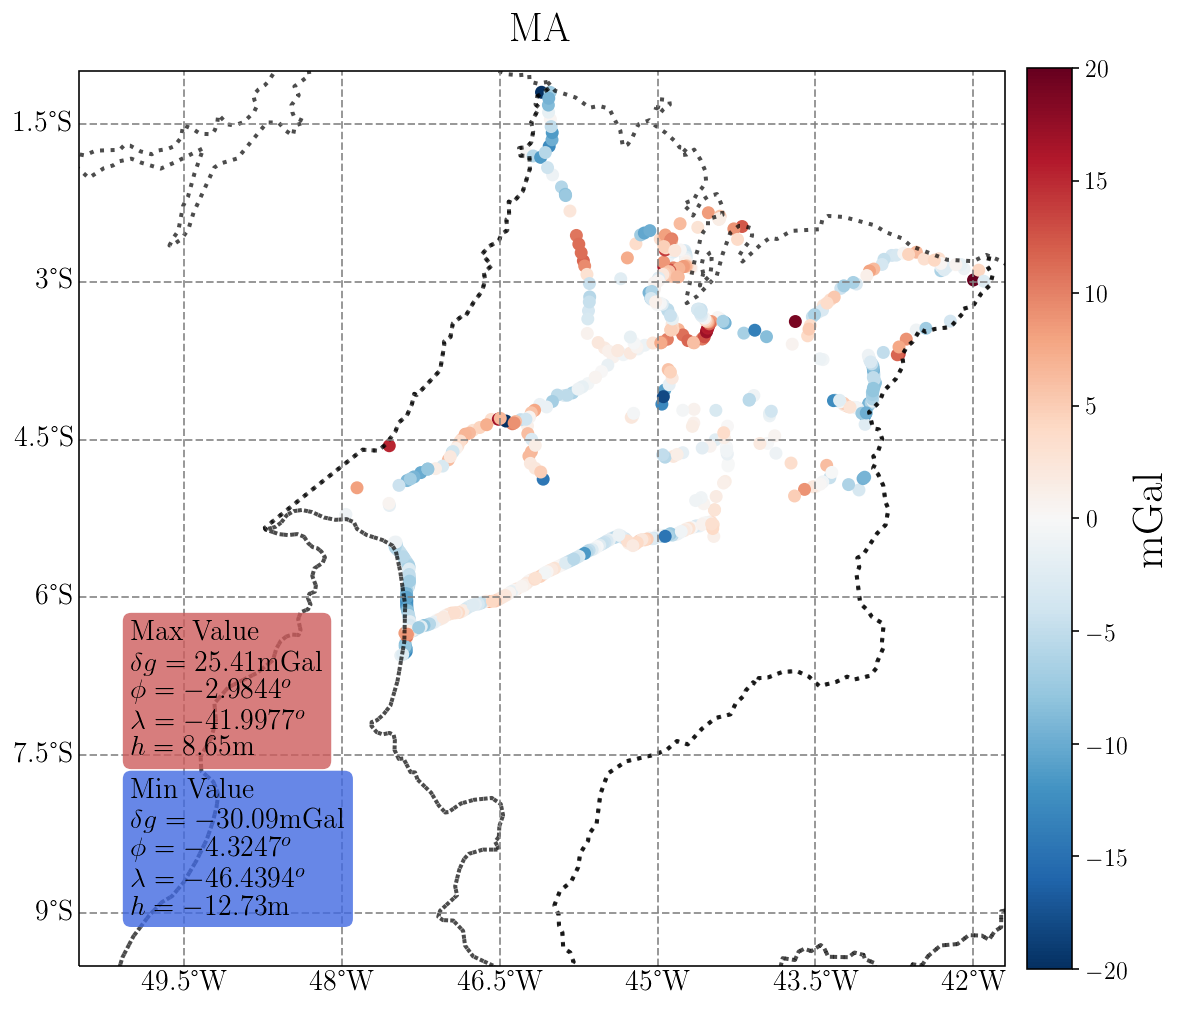

In [27]:
point_map(longitude, latitude, altitude, disturb, uf, fig_size=(10.,12.), region=[-50.5,-41.7,-9.5,-1.], \
          sign=(-50,-50,-7.5,-9), lim_val=(True, 20.), shrink=0.69)

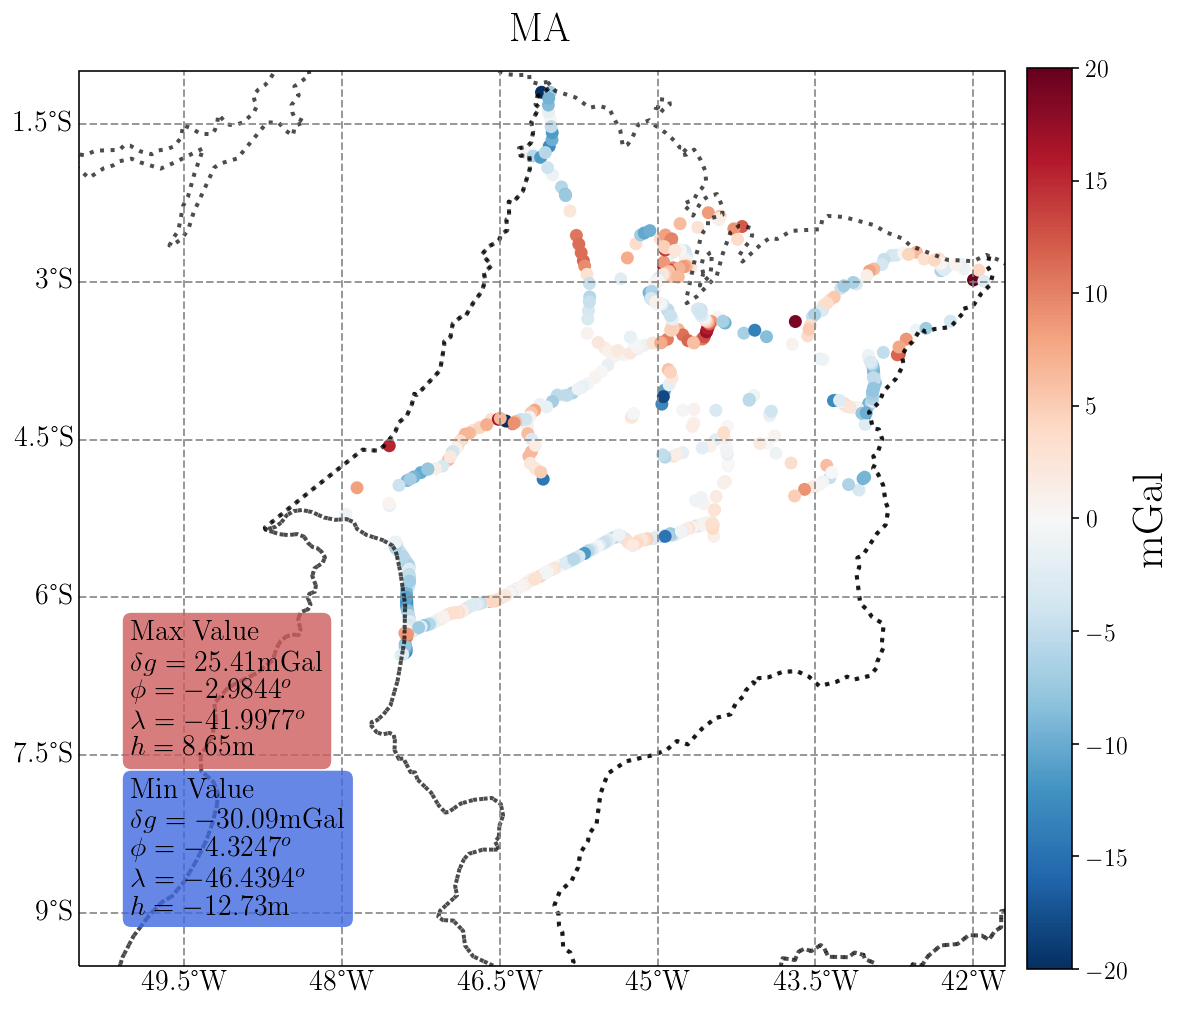

In [28]:
point_map(longitude, latitude, altitude, np.dot(Acc_l, p_L2), uf, fig_size=(10.,12.), \
          region=[-50.5,-41.7,-9.5,-1.], sign=(-50,-50,-7.5,-9), lim_val=(True, 20.), shrink=0.69)

In [29]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [30]:
# new_data = {'LONG':df.LONG, \
#             'LAT':df.LAT, \
#             'ALT':df.ALT, \
#             'BDG':bdg.GRAV.values, \
#             'EIGEN':eigen.GRAV.values, \
#             'DIST':disturb, \
#             'RHO':p_L2, \
#             'RESID':rc}
new_data = {'LONG':longitude, \
            'LAT':latitude, \
            'ALT':altitude, \
            'BDG':np.delete(bdg.GRAV.values,index_max), \
            'EIGEN':np.delete(eigen.GRAV.values,index_max), \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-44.32780,-4.729400,111.800,977998.10,977998.166766,-0.066766,2.098656e+12,0.000384
1,-44.33030,-4.750300,98.310,978002.15,978002.266939,-0.116939,2.159410e+12,0.000365
2,-44.35640,-4.898100,94.610,978005.51,978003.978873,1.531127,3.160106e+12,0.000021
3,-44.37310,-4.913600,96.440,978004.99,978003.795916,1.194084,2.799477e+12,-0.000122
4,-44.44280,-5.041400,118.140,978004.48,978002.814639,1.665361,5.339717e+12,-0.000071
...,...,...,...,...,...,...,...,...
601,-43.38973,-3.204091,48.447,978035.54,978031.803141,3.736859,4.791925e+12,0.000006
602,-44.48577,-5.302927,86.751,978016.51,978013.277394,3.232606,2.315722e+12,-0.000052
603,-46.15702,-5.816454,206.514,977968.56,977965.468859,3.091141,-6.751573e+11,-0.000062
604,-45.23392,-5.508131,129.386,977999.85,977997.976587,1.873413,1.950343e+15,-0.000095


In [31]:
print(df.RESID.min(), df.RESID.max())

-1.4710934902241415 1.0527614264286027


### Upward Continuation

In [32]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [33]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


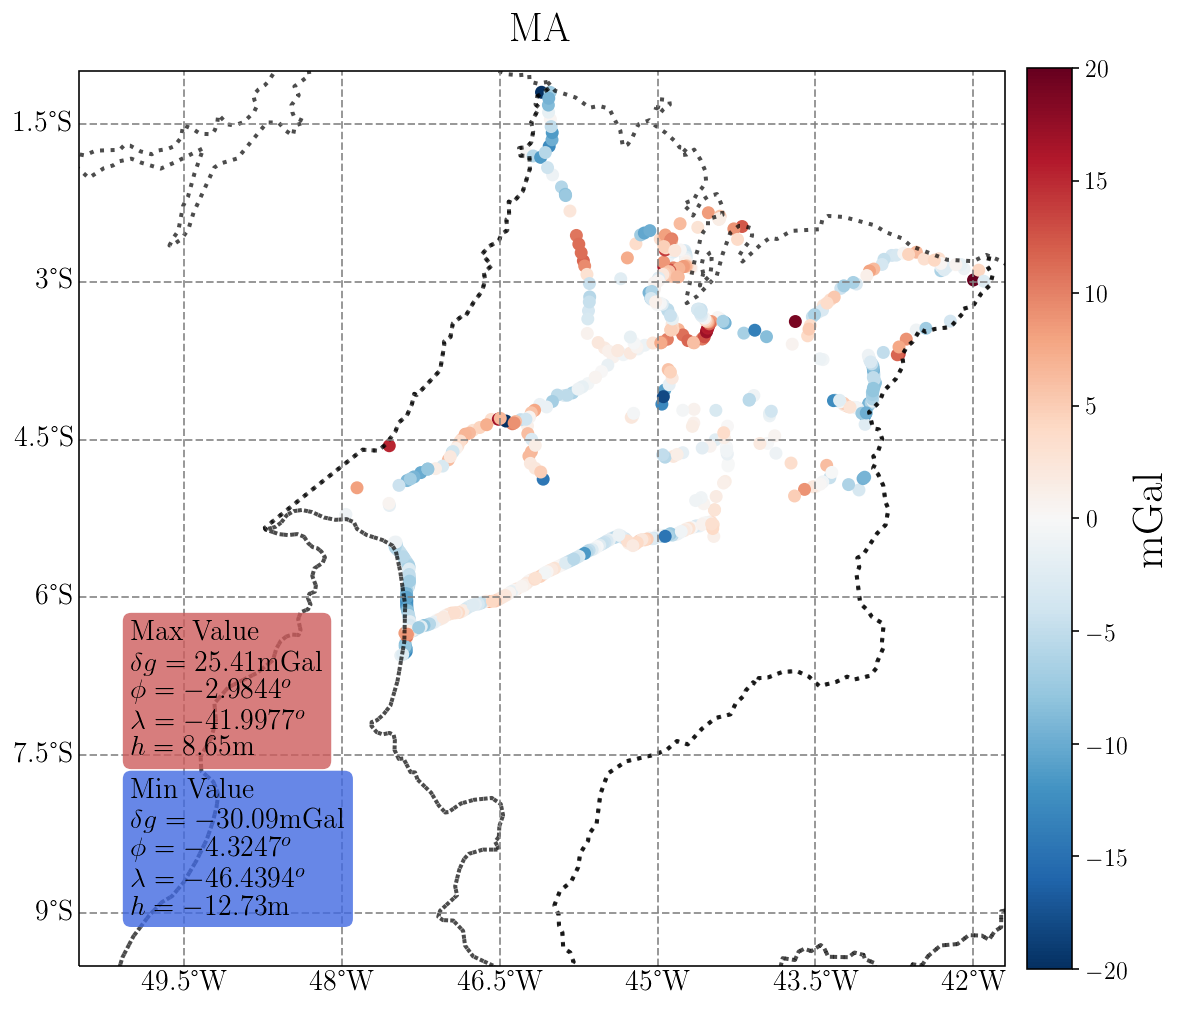

In [34]:
point_map(df.LONG, df.LAT, df.ALT, disturb, uf, fig_size=(10.,12.), region=[-50.5,-41.7,-9.5,-1.], \
          sign=(-50,-50,-7.5,-9), lim_val=(True, 20.), shrink=0.69)

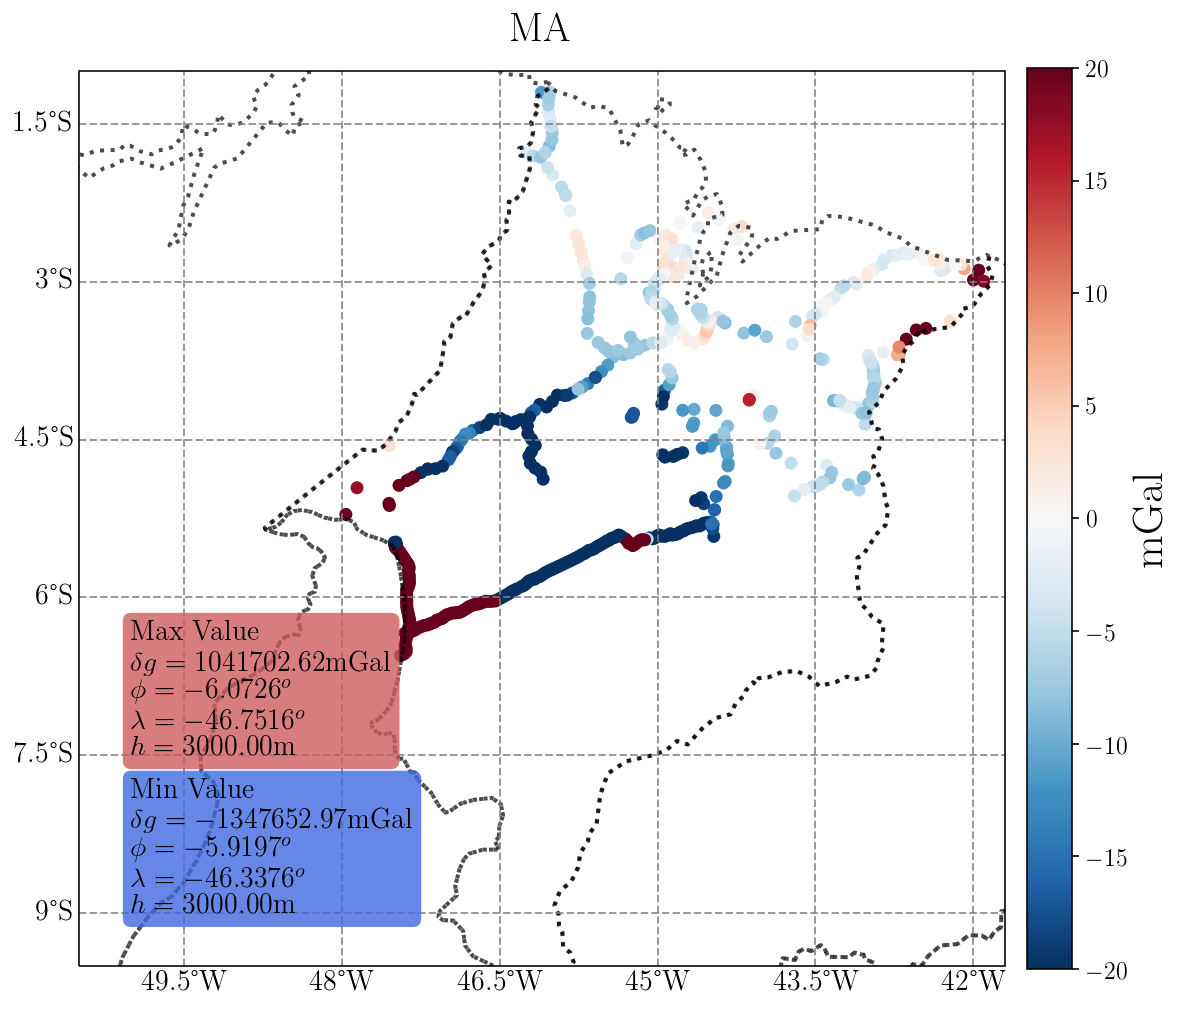

In [35]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(10.,12.), \
          region=[-50.5,-41.7,-9.5,-1.], sign=(-50,-50,-7.5,-9), lim_val=(True, 20.), shrink=0.69)

In [36]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG, df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


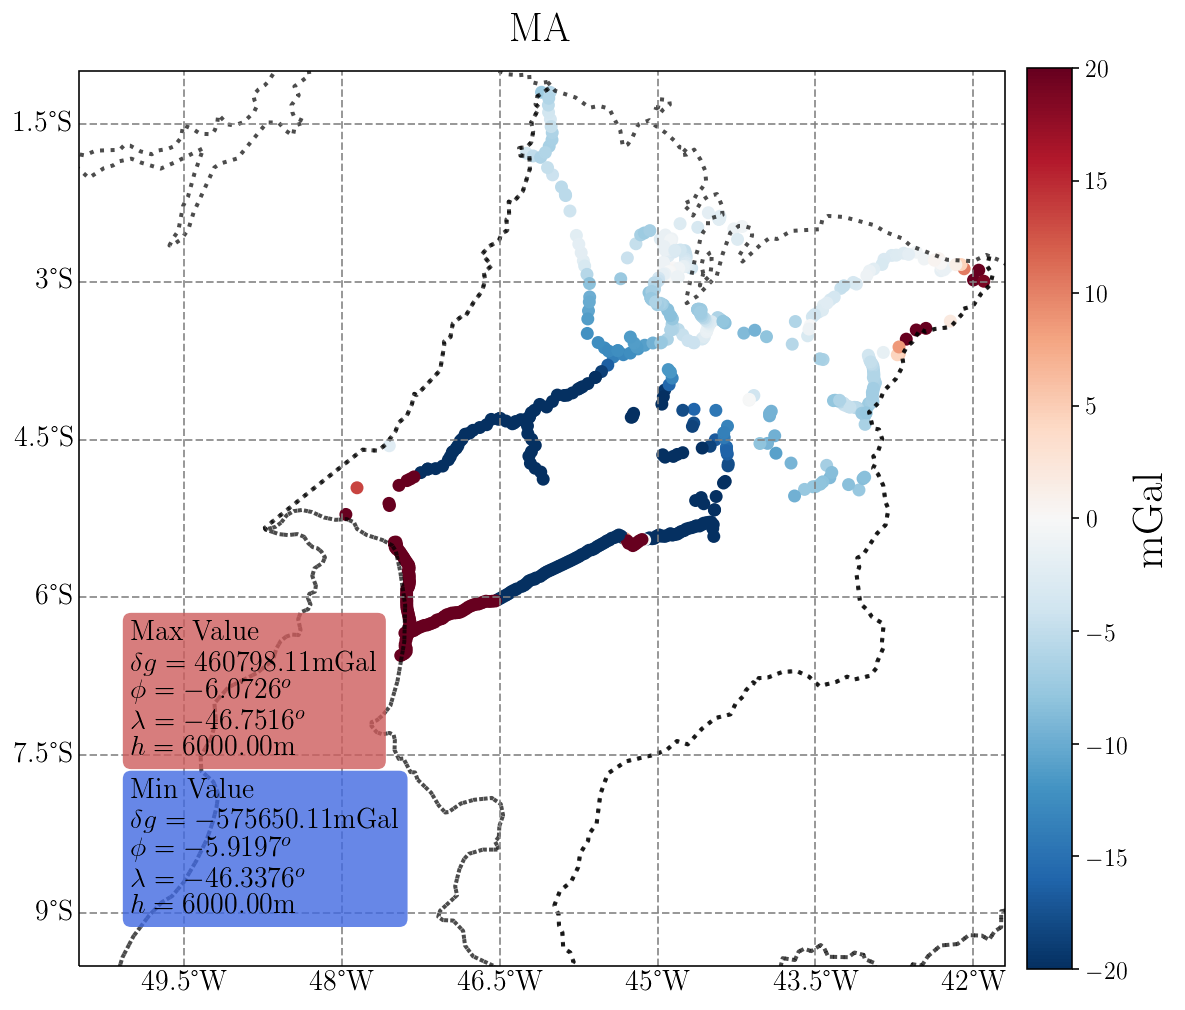

In [37]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(10.,12.), \
          region=[-50.5,-41.7,-9.5,-1.], sign=(-50,-50,-7.5,-9), lim_val=(True, 20.), shrink=0.69)

In [38]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


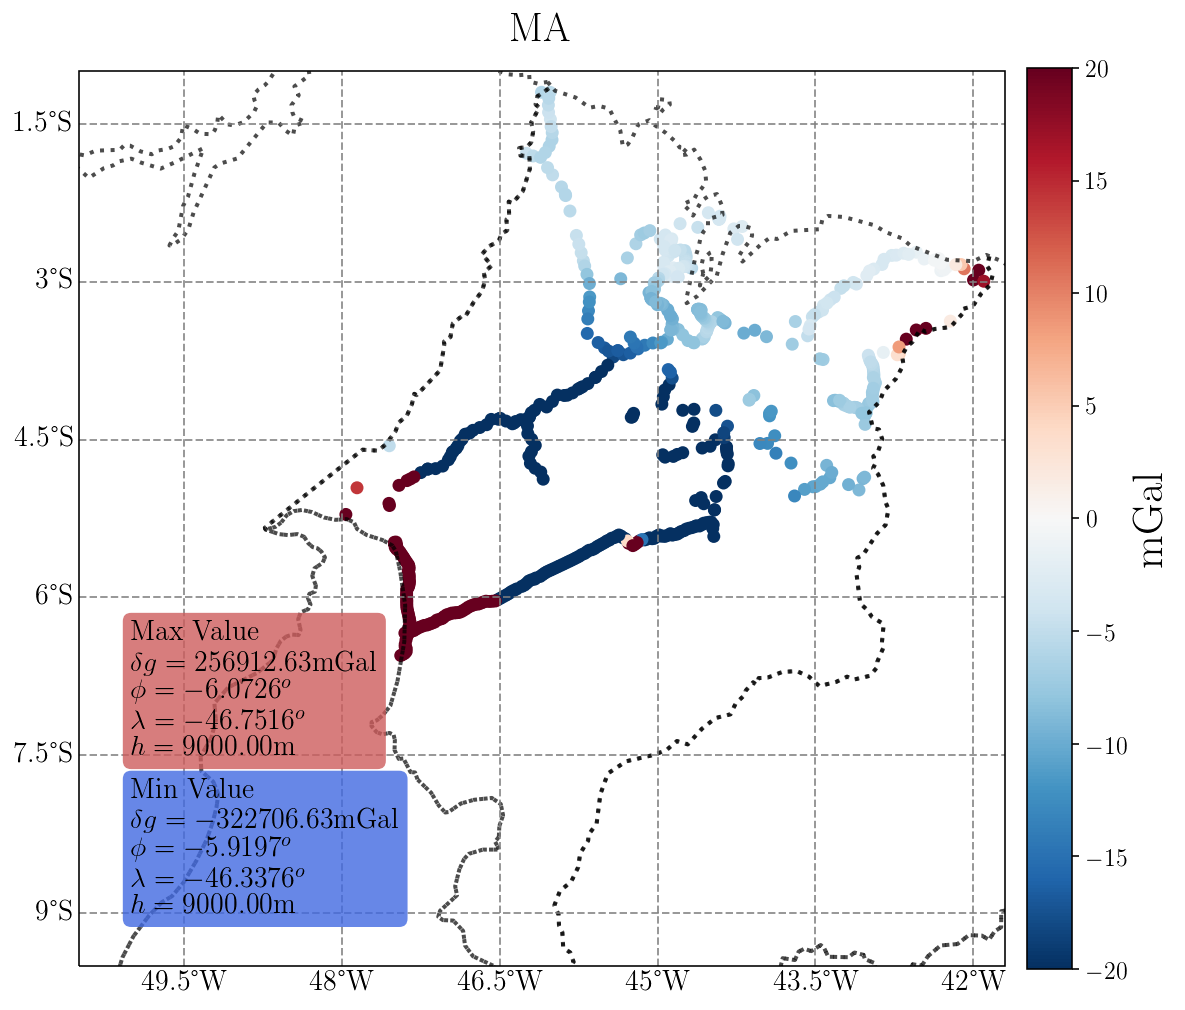

In [39]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(10.,12.), \
          region=[-50.5,-41.7,-9.5,-1.], sign=(-50,-50,-7.5,-9), lim_val=(True, 20.), shrink=0.69)